#  Simple population model
*This Jupyter notebook presents the __Lotka-Volterra model__  between two species.*
This notebook is inspired by the work of [Justin Bois](http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2015/tutorials/r6_sympy.html) and recomputes the models presented in the codes from [PabRod](https://github.com/PabRod/Volterra-Lotka-equations), [INASIC](https://github.com/INASIC/predator-prey_systems) and [JanethGarcía/mpastell](https://github.com/mpastell/SciPy-CookBook/blob/master/originals/LoktaVolterraTutorial_attachments/tutorial_lokta-voltera_v4.py).
We will solve one of the simplest version a classic model in biology: The *Lotka-Volterra* (*Predator-Prey* and *competition model*) equations.

In [1]:
# Numerical package
import numpy as np

#Differential equation numerical solver
from scipy.integrate import odeint

# Import pyplot for plotting
import matplotlib.pyplot as plt

# To compute symbolic expressions
import sympy
# print outputs in LaTeX
sympy.init_printing(use_unicode=True) 

# Interactive manipulations in the notebook
#from ipywidgets import interact

# Magic function to make matplotlib inline
%matplotlib inline

# This enables SVG graphics inline.
%config InlineBackend.figure_formats = {'png', 'retina'}

# Suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Lotka-Volterra equations - Simple version

The Lotka-Volterra equations are a system of differential equations that describe the dynamics of a pair of species that interact. According to the sign of the constant thy can describe a *predator-prey model* or a *competition model*.

The coupled first-order non-linear differential equations are given by

\begin{align}
    \frac{dN_1}{dt} &= r_1 N_1 +b_1N_1N_2,\\[1em]
    \frac{dN_2}{dt} &= r_2 N_2 +b_2N_1N_2,
\end{align}

where
- $t$ = time
- $N_i$ = population size of species $i$, depends on time $t$
- $r_i$ = species $i$ growth rate, or death rate (if it is a predator), in a Malthusian way.
- $b_i$ = inter-species interaction parameters.

If species 2 is the predator and species 1 is the prey, then $b_1$ must be negative (since the predator eats the prey reducing its population) and $b_2$ must be positive since the predator needs the prey to get food.


Usually you can find the following formulation on books, for a predator-prey model:
\begin{align}
    \frac{dR}{dt} &= aR -bRF,\\[1em]
    \frac{dF}{dt} &= -cF +dRF,
\end{align}
where R are rabbits, F are foxes, and a,b,c,d are positive parameters.

Or for a competition model:
\begin{align}
    \frac{dR}{dt} &= aR -bRS,\\[1em]
    \frac{dS}{dt} &= cS -dRS,
\end{align}
where R are rabbits and S are sheep, and a,b,c,d are positive parameters.



## SymPy for Lotka-Volterra

To start working with `sympy` the first thing we have to do is to define the variables that we will use for our symbolic calculations.

In [2]:
# We split it into two definitions to remind us that
# a set of variables is for species 1 and the other one for species 2
# Species 1
r1, b1 = sympy.symbols('r_1 b_1')
# Species 2
r2, b2 = sympy.symbols('r_2 b_2')

#function for species 1 and 2
N1, N2 = sympy.symbols('N_1 N_2', cls=sympy.Function) 

#temporal value
tau = sympy.symbols('tau')

We can now define the differential equations in sympy

In [3]:
diffeq1 = sympy.Eq(N1(tau).diff(tau),  r1 * N1(tau) + b1 * N1(tau)*N2(tau))
diffeq2 = sympy.Eq(N2(tau).diff(tau),  r2 * N2(tau) + b2 * N1(tau)*N2(tau))

And in the `IPython notebook` we can nicely display it as $\LaTeX$.

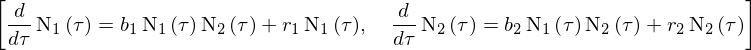

In [4]:
[diffeq1, diffeq2]

### Stationary states
Now we find the steady state, i.e. find when the derivative with respect to time equals to zero.

In [5]:
# set new time-independent variables
N1, N2 = sympy.symbols('N_1 N_2') 
listSubsVarib=[(N1(tau),N1), (N2(tau),N2)]

diffeq1.rhs.subs(listSubsVarib),diffeq2.rhs.subs(listSubsVarib)

In [6]:
ss_N1 = sympy.Eq(diffeq1.rhs.subs(listSubsVarib), 0)
ss_N2 = sympy.Eq(diffeq2.rhs.subs(listSubsVarib), 0)
ss_N1, ss_N2

The steady state solution for both species are:


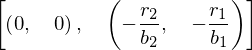

In [7]:
print('The steady state solution for both species are:')
ss_dict_N1N2 = sympy.solve((ss_N1, ss_N2),(N1, N2))
#ss_dict_N1N2 = sympy.solve((ss_N2, ss_N1),[N2, N1], dict=True )
ss_dict_N1N2

So we find that there are two steady state solution: the trivial solution in which both species are extinct, so $N_1 = N_2 = 0$, and the solution $(-\frac{r_2}{b_2},-\frac{r_1}{b_2})$

### Jacobian

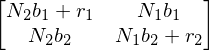

In [8]:
M=sympy.Matrix([ss_N1.lhs, ss_N2.lhs])
Jvar = sympy.Matrix([N1, N2])
J=M.jacobian(Jvar)
J

In [9]:
 #Here we create a numerical version of the Jacobian matrix
d2N_dt2_num = sympy.utilities.lambdify([N1, N2, r1, r2, b1, b2], J, ("math", "mpmath", "sympy"))

In order to avoid rewriting the function we used  `lambdify`.  `lambdify` takes a `sympy` symbolic expression and returns a function that can be either numerically or symbolically evaluated with other values.  This will allow us to evaluate and plot any function that comes out of `sympy`'s toolkit.

The Eigenvalues:


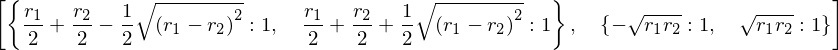

In [10]:
EigenVal = []
for ssSol in ss_dict_N1N2:
    replacements = []
    replacements = [(N, ssSol[i]) for i, N in enumerate([N1, N2])]
    EigenVal.append(J.subs(replacements).eigenvals()) #eigenvals  eigenvects
print('The Eigenvalues:')
EigenVal

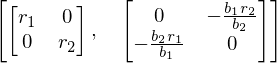

In [11]:
StStateMatrix = []
for ssSol in ss_dict_N1N2:
    replacements = []
    replacements = [(N, ssSol[i]) for i, N in enumerate([N1, N2])]
    StStateMatrix.append(J.subs(replacements)) #eigenvals
StStateMatrix

## Numerical simulation

We can use `scipy`'s numerical solver to run a simulation for this system of equations.

In [12]:
print('We are going to lambdify the following equations:')
ss_N1.lhs, ss_N2.lhs

We are going to lambdify the following equations:


In [13]:
# Generate 'lambdify' functions to numerically evaluate the diff. equations
dN_dt_num = sympy.utilities.lambdify([N1, N2, r1, r2, b1, b2], [ss_N1.lhs, ss_N2.lhs], ("math", "mpmath", "sympy"))

In [14]:
def lotka_voltera_rhs(n1_n2, t, *p):
    '''
    Set up the right hand side (rhs) function for the system 
    (necessary step to feed sympy's odeint function).
    '''
    # unpack the variables
    n1, n2 = n1_n2
    
    # unpack the parameters
    r1, b1, r2, b2 = p
    
    evald_dt=dN_dt_num(n1, n2, r1, r2, b1, b2)
    
    return np.array([evald_dt[0], 
                    evald_dt[1]])

For teh first three examples we will recompute the models presented in [PabRod](https://github.com/PabRod/Volterra-Lotka-equations), [INASIC](https://github.com/INASIC/predator-prey_systems) and [JanethGarcía/mpastell](https://github.com/mpastell/SciPy-CookBook/blob/master/originals/LoktaVolterraTutorial_attachments/tutorial_lokta-voltera_v4.py).
We will first define the parameters and numerically solve the system.

### Example 1

In [15]:
# let's set the parameter values.
"""" definition of lotka-volterra parameters"""
# r1: birth rate of rabbits
# r2: the natural dying rate of fox, when there's no rabbit
R = [1., -0.5] 

# b1: death rate of rabbits due to predation
# b2: birth rate of foxes due to predation
#Note that b2/(-b1) is the factor that describes how many eaten rabbits give birth to a new fox
B = [-0.1, 0.02]

argsPar = (R[0], B[0], R[1], B[1])

# Initial population size
n1_n2_0 = np.array([100, 20])
#n1_n2_0 = np.array([-r2/b2, -r1/b1]) #Steady state

# Time points we want to consider
t = np.linspace(0, 50, 10000)

argsPar
# Now let's use odeint to solve the function
sol_n1n2, infodict = odeint(lotka_voltera_rhs, n1_n2_0, t, args=argsPar, full_output = True )
infodict['message']                     # >>> 'Integration successful.'

'Integration successful.'

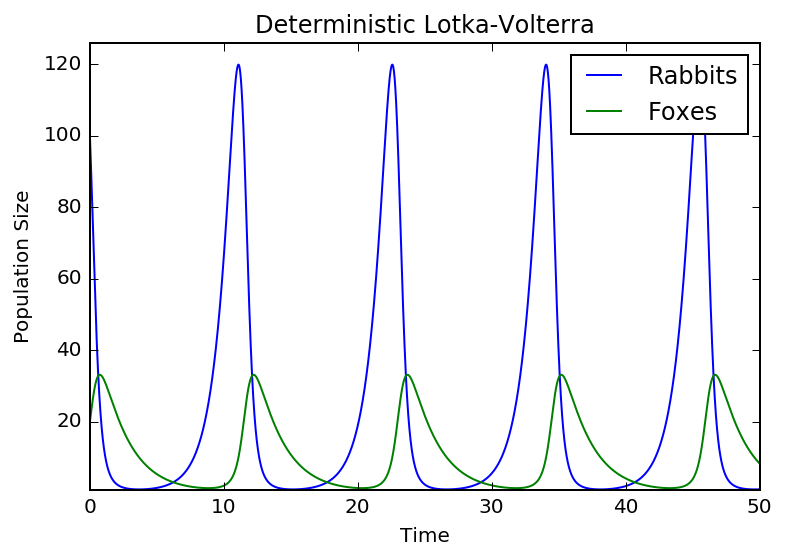

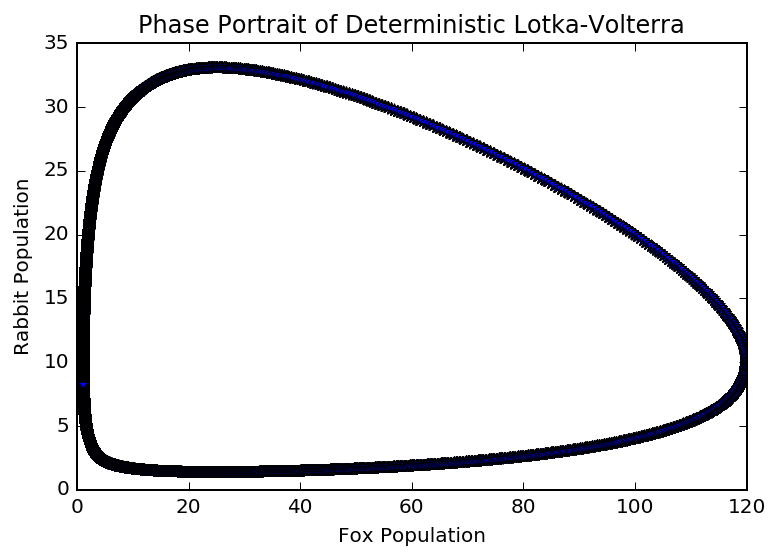

In [16]:
""" visualization """

# visualization of deterministic populations against time
plt.plot(t, sol_n1n2[:, 0])
plt.plot(t, sol_n1n2[:, 1])
plt.xlabel('Time')
plt.ylabel('Population Size')
plt.legend(('Rabbits', 'Foxes'))
plt.title('Deterministic Lotka-Volterra')
ymin = np.amin(sol_n1n2)
ymax = np.amax(sol_n1n2)
plt.ylim(ymin*0.95, ymax*1.05)
plt.show()

# deterministic phase portrait
plt.plot(sol_n1n2[:, 0],sol_n1n2[:, 1],'*')
plt.xlabel('Fox Population')
plt.ylabel('Rabbit Population')
plt.title('Phase Portrait of Deterministic Lotka-Volterra')
plt.show()

### Example 2

In [17]:
# let's set the parameter values.
"""" definition of Lotka-Volterra parameters"""
R = [1, -1] 
B = [-0.2, 1]
argsPar = (R[0], B[0], R[1], B[1])

# Initial population size
n1_n2_0 = np.array([2, 3])
#n1_n2_0 = np.array([-r2/b2, -r1/b1]) #Steady state

# Time points we want to consider
t = np.linspace(0, 50, 10000)

argsPar
# Now let's use odeint to solve the function
sol_n1n2, infodict = odeint(lotka_voltera_rhs, n1_n2_0, t, args=argsPar, full_output = True )
infodict['message']                     # >>> 'Integration successful.'

'Integration successful.'

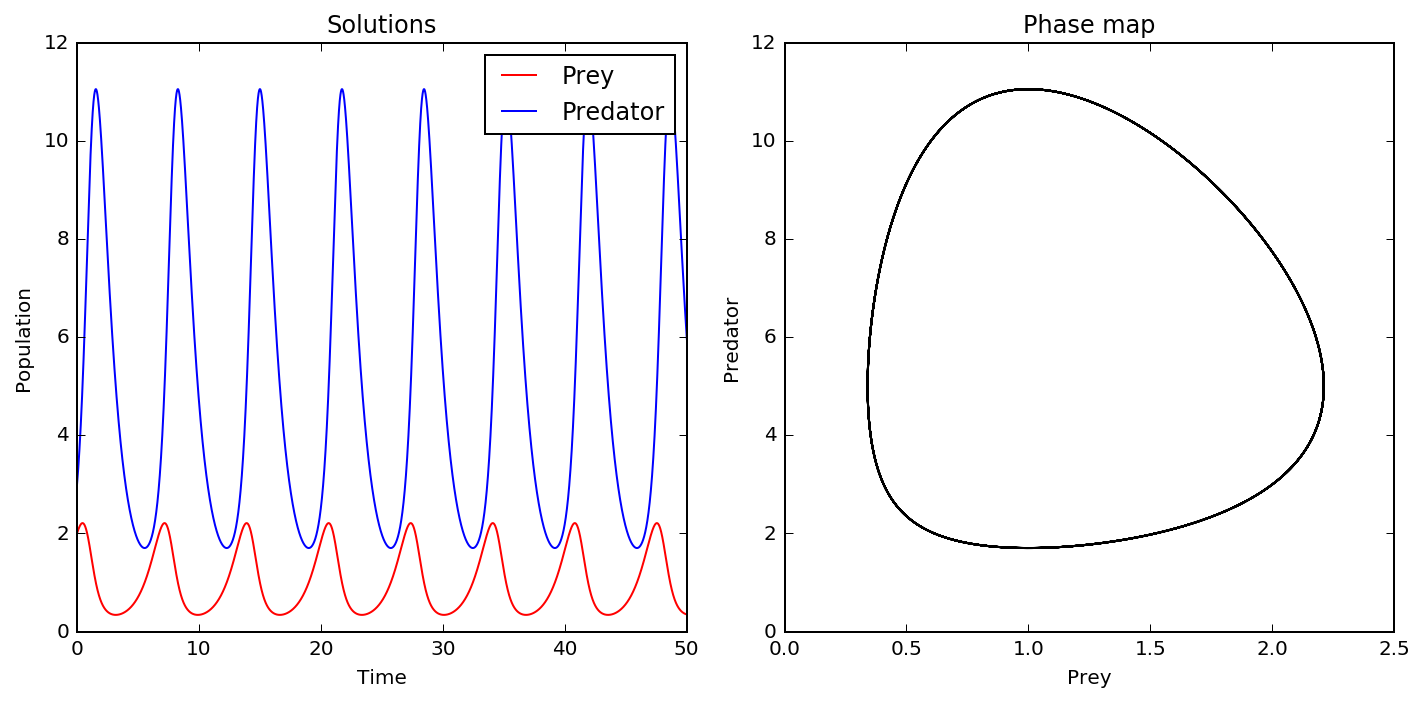

In [18]:
""" visualization """

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (10,5))

axes[0].plot(t, sol_n1n2[:,0], 'r')
axes[0].plot(t, sol_n1n2[:,1], 'b')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Population')
axes[0].set_title('Solutions')
axes[0].legend(('Prey','Predator'))
ymin = np.amin(sol_n1n2)
ymax = np.amax(sol_n1n2)

axes[1].plot(sol_n1n2[:,0], sol_n1n2[:,1], 'k')
axes[1].set_xlabel('Prey')
axes[1].set_ylabel('Predator')
axes[1].set_title('Phase map')
    
fig.tight_layout()



### Example 3

In [19]:
# let's set the parameter values.
R = [1., -1.5]
B = [-0.1, 0.1*0.75]
argsPar = (R[0], B[0], R[1], B[1])

# Initial population size
n1_n2_0 = np.array([10, 5])

# Time points we want to consider
t = np.linspace(0, 15, 1000)

argsPar
# Now let's use odeint to solve the function
sol_n1n2, infodict = odeint(lotka_voltera_rhs, n1_n2_0, t, args=argsPar, full_output = True )
infodict['message']                     # >>> 'Integration successful.'

'Integration successful.'

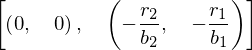

In [20]:
ReplParamVal=[(r1,R[0]), (r2,R[1]),(b1,B[0]), (b2,B[1])]
ss_dict_N1N2

In [21]:
EqPoint=[[elem[0].subs(ReplParamVal),elem[1].subs(ReplParamVal)] for elem in ss_dict_N1N2]
EqPoint

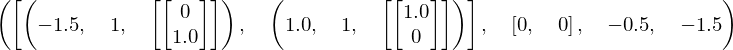

In [22]:
Eigen=[]
Trace=[]
Deter=[]
for Matrix in StStateMatrix:
    Eigen.append(Matrix.subs(ReplParamVal).eigenvects())
    Trace.append(Matrix.subs(ReplParamVal).trace())
    Deter.append(Matrix.subs(ReplParamVal).det())

Eigen[0], EqPoint[0], Trace[0], Deter[0]


Looking at the eigenvectors of the point $(0,0)$ we can see that they are both real, one is negative $-1.5$ and the other is positive $1$, negative trace and negative determinant: it is a saddle.

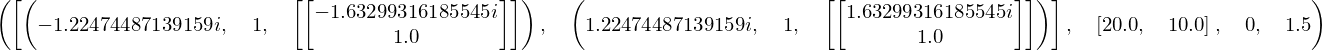

In [23]:
Eigen[1], EqPoint[1], Trace[1], Deter[1]

Looking at the eigenvectors of the point $(-\frac{r_2}{b_2},-\frac{r_1}{b_2})$ we can see that they are both imaginary, zero trace and positive determinant: it is a center.                                                                                                                                                                                                            

We will now plot the solution.

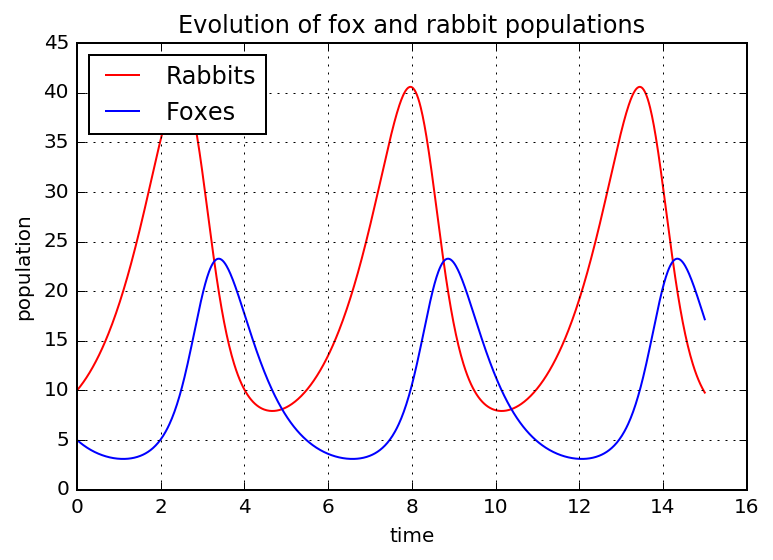

In [24]:
f1 = plt.figure()
plt.plot(t, sol_n1n2[:, 0], 'r-', label='Rabbits')
plt.plot(t, sol_n1n2[:, 1]  , 'b-', label='Foxes')
plt.grid()
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('population')
plt.title('Evolution of fox and rabbit populations')
plt.show()
f1.savefig('OutImage/rabbits_and_foxes_1.png')

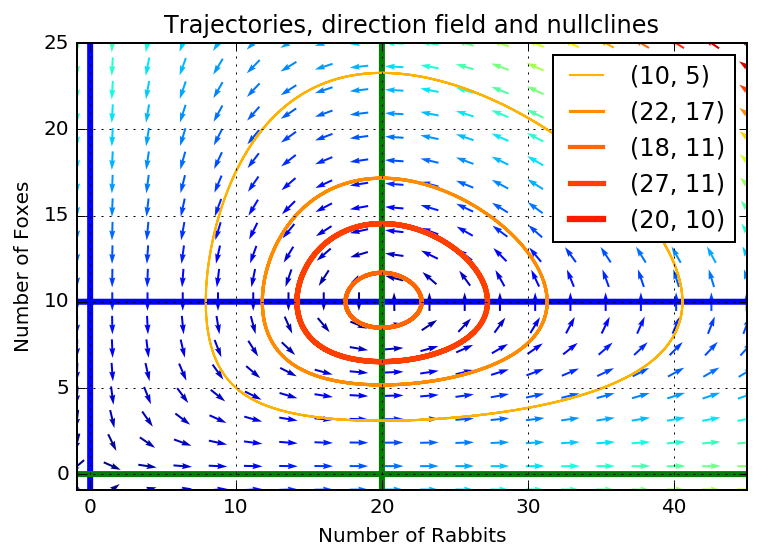

In [25]:
X_f1= np.array(EqPoint[1][:], dtype=np.float64)
X_fs= np.array(n1_n2_0 , dtype=np.float64) #n1_n2_0 EqPoint[1][:]

StartPoints = np.array([X_fs, [X_f1[0]+2,X_f1[1]+7], [X_f1[0]-2,X_f1[1]+1] , [X_f1[0]+7,X_f1[1]+1], X_f1])  # position of X0 between X_f0 and X_f1
values  = np.linspace(0.3, 0.9, len(StartPoints)) 

f2 = plt.figure()
# plot trajectories
for point, v in zip(StartPoints, values): 
    X0 = point                     # starting point (internal)
    sol_n1n2 = odeint(lotka_voltera_rhs, np.transpose(X0), t, args=argsPar)
    plt.plot( sol_n1n2[:,0], sol_n1n2[:,1], lw=3.5*v, color=plt.cm.autumn_r(v), label='(%.f, %.f)' % ( X0[0], X0[1]) )

#-------------------------------------------------------
# define a grid and compute direction at each point
ymax = plt.ylim()[1]                     # get axis limits
xmax = plt.xlim()[1] 
ymin = -.9
xmin = -.9
nb_points   = 20                      

x = np.linspace(xmin, xmax, nb_points)
y = np.linspace(ymin, ymax, nb_points)

X1 , Y1  = np.meshgrid(x, y)                       # create a grid
DX1, DY1 = dN_dt_num(X1, Y1,R[0],R[1],B[0],B[1])   # compute growth rate on the grid
M = (np.hypot(DX1, DY1))                           # Norm of the growth rate 
M[ M == 0] = 1.                                    # Avoid zero division errors 
DX1 /= M                                           # Normalize each arrows
DY1 /= M                                  
#-------------------------------------------------------
# Draw direction fields, using matplotlib 's quiver function
Q = plt.quiver(X1, Y1, DX1, DY1, M, pivot='mid', cmap=plt.cm.jet)



# Now find the nullclines.  Use matplotlib's contour routine to find the zero level.
# We will need a fine mesh, reevaluate DX1 and DY1 on the finer grid, and use contour 
# to find the level curves
x = np.linspace(xmin, xmax, nb_points*10)
y = np.linspace(ymin, ymax, nb_points*10)
X1 , Y1  = np.meshgrid(x, y)                    
dX1, dY1 = dN_dt_num(X1, Y1, R[0],R[1],B[0],B[1])
plt.contour(X1, Y1, dX1, levels=[0], linewidths=3, colors='blue')
plt.contour(X1, Y1, dY1, levels=[0], linewidths=3, colors='green')


plt.title('Trajectories, direction field and nullclines')
plt.xlabel('Number of Rabbits')
plt.ylabel('Number of Foxes')
plt.legend()
plt.grid()
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()
f2.savefig('OutImage/rabbits_and_foxes_2.png')

### Example 4

In this example we focus on the *Lotka-Volterra competition model*, also presented as the "rabbits vs. sheep" problem.

We suppose that both species are competing for the same food supply (grass). The equations are:
\begin{align}
    \dot{x} &= x -0.1xy,\\[1em]
    \dot{y} &= 1.5y-0.075xy,
\end{align}

where
- $x(t)$ = population of rabbits,
- $y(t)$ = population of sheep

(see S.Strogatz - Nonlinear Dynamics and Chaos)

In [26]:
# let's set the parameter values.
R = [1., 1.5] #
B = [-0.1, -0.075] #
argsPar = (R[0], B[0], R[1], B[1])

# Initial population size
n1_n2_0 = np.array([3, 1])

# Time points we want to consider
t = np.linspace(0, 5, 1000)

argsPar
# Now let's use odeint to solve the function
sol_n1n2, infodict = odeint(lotka_voltera_rhs, n1_n2_0, t, args=argsPar, full_output = True )
infodict['message']                     # >>> 'Integration successful.'

'Integration successful.'

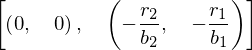

In [27]:
ReplParamVal=[(r1,R[0]), (r2,R[1]),(b1,B[0]), (b2,B[1])]
ss_dict_N1N2

In [28]:
EqPoint=[[elem[0].subs(ReplParamVal),elem[1].subs(ReplParamVal)] for elem in ss_dict_N1N2]
EqPoint

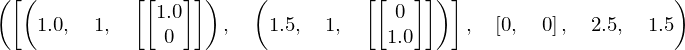

In [29]:
Eigen=[]
Trace=[]
Deter=[]
for Matrix in StStateMatrix:
    Eigen.append(Matrix.subs(ReplParamVal).eigenvects())
    Trace.append(Matrix.subs(ReplParamVal).trace())
    Deter.append(Matrix.subs(ReplParamVal).det())

Eigen[0], EqPoint[0], Trace[0], Deter[0]


Looking at the eigenvectors of the point $(0,0)$ we can see that they are both real and positive, one $2.5$ and the other $1$. We have positive trace and positive determinant: it is a saddle.   

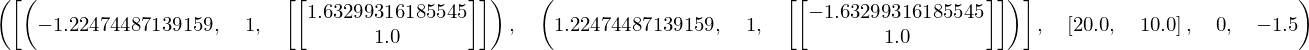

In [30]:
Eigen[1], EqPoint[1], Trace[1], Deter[1]

Looking at the eigenvectors of the point $(-\frac{r_2}{b_2},-\frac{r_1}{b_2})$ we can see that they are both real, one the opposite of the other. Zero trace and negative determinant: it is a saddle.                                                                                                                                                                                                            

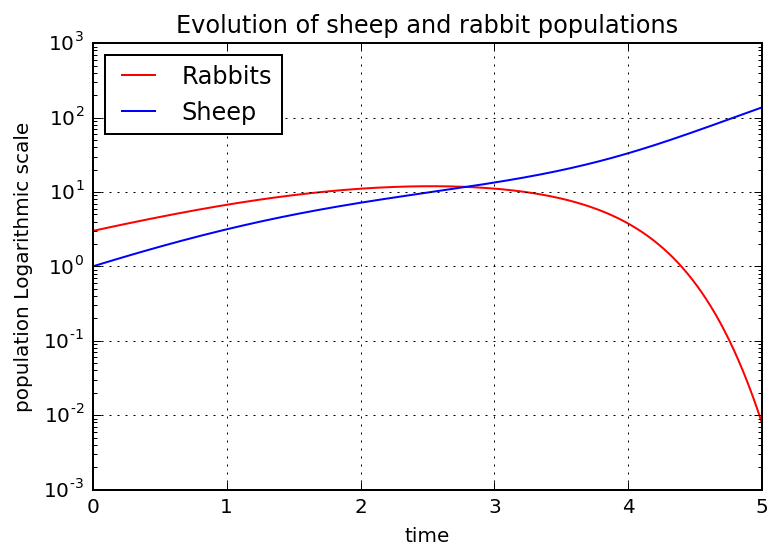

In [31]:
f1 = plt.figure()
plt.semilogy(t, sol_n1n2[:, 0], 'r-', label='Rabbits')
plt.semilogy(t, sol_n1n2[:, 1]  , 'b-', label='Sheep')
plt.grid()
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('population Logarithmic scale')
plt.title('Evolution of sheep and rabbit populations')
plt.show()
f1.savefig('OutImage/rabbits_and_sheep_1.png')

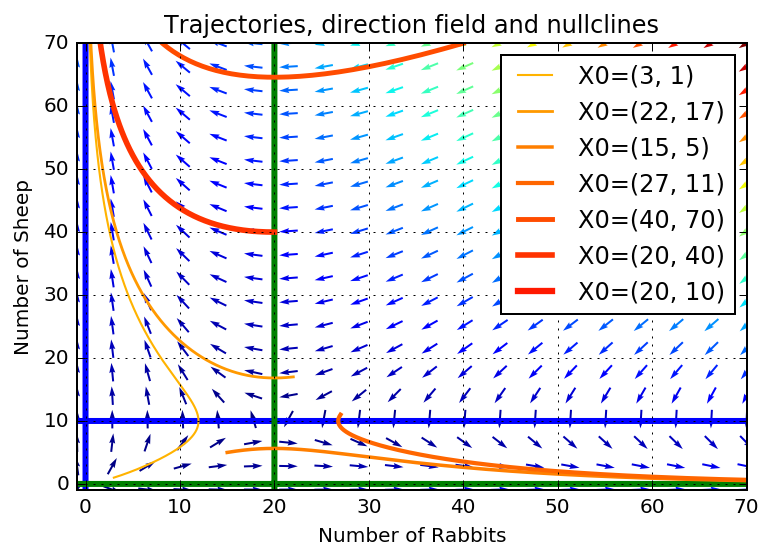

In [32]:
X_f1= np.array(EqPoint[1][:], dtype=np.float64)
X_fs= np.array(n1_n2_0 , dtype=np.float64) #n1_n2_0 EqPoint[1][:]

StartPoints = np.array([X_fs, [X_f1[0]+2,X_f1[1]+7],[15,5], [X_f1[0]+7,X_f1[1]+1], [40,70], [20,40], X_f1])  # position of X0 between X_f0 and X_f1
values  = np.linspace(0.3, 0.9, len(StartPoints)) 


f2 = plt.figure()
# plot trajectories
for point, v in zip(StartPoints, values): 
    X0 = point                     # starting point (internal)
    sol_n1n2 = odeint(lotka_voltera_rhs, np.transpose(X0), t, args=argsPar)
    plt.plot( sol_n1n2[:,0], sol_n1n2[:,1], lw=3.5*v, color=plt.cm.autumn_r(v), label='X0=(%.f, %.f)' % ( X0[0], X0[1]) )

#-------------------------------------------------------
# define a grid and compute direction at each point
ymax = 70 #plt.ylim()[1]#plt.ylim(ymin=0)[1]                   # get axis limits
xmax = 70 #plt.xlim()[1] #plt.xlim(xmin=0)[1] 
ymin = -.9
xmin = -.9

nb_points   = 20                      
x = np.linspace(xmin, xmax, nb_points)
y = np.linspace(ymin, ymax, nb_points)
X1 , Y1  = np.meshgrid(x, y)                       # create a grid
DX1, DY1 = dN_dt_num(X1, Y1,R[0],R[1],B[0],B[1])   # compute growth rate on the gridt
M = (np.hypot(DX1, DY1))                           # Norm of the growth rate 
M[ M == 0] = 1.                                    # Avoid zero division errors 
DX1 /= M                                           # Normalize each arrows
DY1 /= M                                  
#-------------------------------------------------------
# Draw direction fields, using matplotlib 's quiver function
Q = plt.quiver(X1, Y1, DX1, DY1, M, pivot='mid', cmap=plt.cm.jet)



# Now find the nullclines.  Use matplotlib's contour routine to find the zero level.
# We will need a fine mesh, reevaluate DX1 and DY1 on the finer grid, and use contour 
# to find the level curves
x = np.linspace(xmin, xmax, nb_points*10)
y = np.linspace(ymin, ymax, nb_points*10)
X1 , Y1  = np.meshgrid(x, y)                    
dX1, dY1 = dN_dt_num(X1, Y1, R[0],R[1],B[0],B[1])
plt.contour(X1, Y1, dX1, levels=[0], linewidths=3, colors='blue')
plt.contour(X1, Y1, dY1, levels=[0], linewidths=3, colors='green')


plt.title('Trajectories, direction field and nullclines')
plt.xlabel('Number of Rabbits')
plt.ylabel('Number of Sheep')
plt.legend()
plt.grid()
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()
f2.savefig('OutImage/rabbits_and_sheep_2.png')


##  Further references:
See more on Pyhton programmin:

* [Stability analysis with Python](http://systems-sciences.uni-graz.at/etextbook/sw2/phpl_python.html).

* [nullclines for nonlinear ODEs](http://scipy-user.scipy.narkive.com/RU19ShQ4/nullclines-for-nonlinear-odes).

